# 0. Wstep
Notebook stanowi mój pierwszy własny projekt na Kaggle oprócz tutorialu z ML.
Dotyczy on oczywiście wszystkim znanego zadania Titanica na Kagglu, a więc przewidzenia czy pasażer przeżyje lub czy zginie podczas katastrofy na Titanicu, który zatonął w 1912 roku, w zależności od różnych cech, które zostaną omówione w kolejnym punkcie. Źródła, na których bazowałem podałem na końcu notebooka.

### Spis treści:
1. Wczytanie danych i wstępny ich przegląd
2. Oczyszczenie danych, wstępna wizualizacja i wstępny Feature Engineering
3. Sprawdzenie zależności między zmiennymi
4. Wstępny model, cross-validation, krzywe uczenia (learning_curves), porównanie różnych modeli i wybór jednego (XGBoosta)
5. Feature Importance - sprawdzenie jak poszczególne cechy wpływają na wynik, odrzucenie zbędnych
6. Próba tuningu parametrów XGBoosta z użyciem GridSearchCV
7. Wnioski

### Stosowane rozwiązania:
W notebooku przedstawiono różne operacje na danych z pomocą Pandasa, wizualizacje z pomocą Matplotlib oraz Seaborn, liczne operacje z użyciem Sklearn: imputacje pustych danych, normalizacje, skalowanie danych, tworzenie modeli ML, tworzenie cross-validation, operanie i analiza krzywych uczenia,dobór i odrzucenie zmiennych z użyciem feature importance, sprawdzanie ich zależnośći między sobą (heatmapy) oraz ich wpływ na wynik ,modelowanie z użyciem XGBoosta,  próba optymalizacji i  tuning jego parametrów z użyciem GridSeachCV.

### Źródła poza stackoverflow, dokumentacji bibliotek:
* https://alexiej.github.io/kaggle-titanic/
* https://machinelearningmastery.com
* https://github.com/dataworkshop/webinar-titanic


# 1 .Wczytanie danych i wstępny ich przegląd i wizualizacja

## 1.1 Import niezbędnych modułów

In [277]:
import numpy as np #do roznych obliczen
import pandas as pd #do operacji na danych
import matplotlib.pyplot as plt #do wykresow
import seaborn as sns #do jeszcze ladniejszych wykresow
%matplotlib inline 
pd.set_option('display.max_columns', 500)

## 1.2 Wczytanie danych i złączenie zbiorów

In [278]:
#Wczytujemy dane treningowe i testowe w postaci *.csv.
#header=0 - informuje, gdzie znajduje się wiersz z nazwami kolumn
#index_col=0 - informuje, gdzie znajduje się kolumna, po której indeksujemy nasz zbiór
df_train = pd.read_csv('../input/train.csv', header=0,index_col=0)
df_test = pd.read_csv('../input/test.csv', header=0,index_col=0)

#Polaczenie zbioru treningowego z testowym, by mozna je bylo razem modyfikowac
df_all=pd.concat([df_train, df_test], sort=False)

#Nadanie nazw dataframe'om
df_train.name='Train Dataset'
df_all.name='All Dataset'
df_test.name='Test Dataset'

## 1.3 Wstępny przegląd danych
Przyjżyjmy się teraz co zawiera nasz zbiór. Głównym celem jest przewidzenie wartości wartości zmiennej Survival, a więc informacji czy pasażer przeżył, czy też nie, przy użyciu 9-ciu pozostałych zmiennych (predyktorów), które zostały opisane poniżej:

<br>-PassengerID - unikalny numer pasażera
<br>-Survival - informacja czy dany pasażer przeżył katastrofę, czy też nie. 0 - Nie, 1 - Tak
<br>-Pclass – klasa | (1 = pierwsza; 2 = druga; 3 = trzecia).
<br>-Name – imię i nazwisko pasażera.
<br>-Sex – płeć pasażera.
<br>-Sibsp – liczba małżonków, lub rodzeństwa na pokładzie.
<br>-Parch – liczba rodziców, lub dzieci na pokładzie.
<br>-Ticket – numer biletu.
<br>-Fare – opłata za bilet.
<br>-Cabin – kabina.
<br>-Embarked – port startowy (C = Cherbourg; Q = Queenstown; S = Southampton).


### Wyświetlmy teraz podstawowe informacje o datasetcie
- Przykładowy sampel z 3 wierszami, by zapoznać się z wyglądem datasetu (df.sample(3))
- Zestawienie typów danych zbioru wraz z nazwami kolumn oraz liczbą wystąpień (df.info())
- Wymiary datasetu (df.shape)
- Zestawienie braków w danych (df.isnull().sum())

In [279]:
#Funkcja ulatwiajaca wyswietlanie informacji o zbiorze w konsoli
def print_some_info(df):
    '''Funkcja do wyswietlania informacji o datasecie w formie zbiorczej'''
    
    names_print=['Przykladowy sampel', 'Zestawienie nazw kolumn, liczby wystapien i typow danych', 'Wymiar datasetu',
                 'Brak danych w poszczegolnych kolumnach']
    n_len=[int((100-len(name))/2) for name in names_print ]
    
    print('\n \n Zestawienie dla datasetu: '+ '*'*len(df.name) + df.name  + '*'*len(df.name) )
    
    print('\n'+'~'*n_len[0] + names_print[0]  + '~'*n_len[0]+'\n')
    print(df.sample(4))
    print('\n'+'~'*n_len[1] + names_print[1]  + '~'*n_len[1]+'\n')
    print(df.info())
    print('\n'+'~'*n_len[2] + names_print[2]  + '~'*n_len[2]+'\n')
    print(df.shape)
    print('\n'+'~'*n_len[3] + names_print[3]  + '~'*n_len[3]+'\n')
    print(df.isnull().sum())
df_all.describe

#Wywolanie funkcji dla datesetow
print_some_info(df_all)
print_some_info(df_train)
print_some_info(df_test)

#Inne przydatne funkcje do wstepnej analizy zbioru:
#df.head(n) #pokazuje n pierwszych wierszy df
#df.tail(n) #pokazuje n ostatnich wierszy df
#df.describe() #opis statystyczny
#df[-5:], df[:10] #filtrowanie po wierszach (5 ostatnich, 10 pierwszych)
#df[["Age","Pclass"]][5:30] #filtrowanie po wierszach z wyborem kolumn
#df[(df['Age'] > 5.0) & (df['Age'] < 7.0 ) ] #filtorwanie po kolumnie
#df[(df['Cabin'].str.contains('B2',na=False)) ] #flitrowanie po tekscie
#df[df['Embarked'].isnull()] #filtrowanie po pustych wartosciach
#df.select_dtypes(include=[np.int, np.float]).head() #flitrowanie po typie danych
#df.groupby(['Pclass','Sex'])['Survived'].sum() # grupowanie po kategorii


 
 Zestawienie dla datasetu: ***********All Dataset***********

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Przykladowy sampel~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

             Survived  Pclass                  Name   Sex   Age  SibSp  Parch  \
PassengerId                                                                     
736               0.0       3  Williams, Mr. Leslie  male  28.5      0      0   
472               0.0       3       Cacic, Mr. Luka  male  38.0      0      0   
607               0.0       3     Karaic, Mr. Milan  male  30.0      0      0   
215               0.0       3   Kiernan, Mr. Philip  male   NaN      1      0   

             Ticket     Fare Cabin Embarked  
PassengerId                                  
736           54636  16.1000   NaN        S  
472          315089   8.6625   NaN        S  
607          349246   7.8958   NaN        S  
215          367229   7.7500   NaN        Q  

~~~~~~~~~~~~~~~~~~~~~~Zestawienie nazw kolumn, liczby wystapien i typ

## Po wstępnej analizie można zauważyć, że:
1.  W zbiorze treningowym brakuje większości (687 z 891) wartości dotyczących zmiennej Cabin (nr kabiny), ale za pewien substytut można informację o klasie Pclass. I zmienną Cabin trzeba będzie usunąć.
2. Brakuje także części informacji o wieku (dla zbioru treningowego 177 z 891), które trzeba będzie imputować.
3. Brakuje pojedynczych danych dla zmiennych Ebarked i Fare.
4.  Zbiór treningowy zawiera kompletne informacja o zmiennej wynikowej (czy ktoś przeżył, czy nie) - Survived, więc nie będzie trzeba wyrzucać wierszy ze zbioru.
5. Zmienne Sex, Embarked to zmienne kategoryczne i trzeba będzie je odpowiednio zakodować.
6. Zmienne Age, Fare podane są jako liczby zmiennoprzecinkowy (float64), ale dla późniejszych obliczeń zapewne będzie stworzyć także z nich zmienne kategoryczne i zakodować.


# 2.Oczyszczenie danych, wstępna wizualizacja i wstępny Feature Engineering
W kolejnym rozdziale przyjżymy się każdej zmiennej, która jest używana do predykcji. Przeprowadzimy wstępną wizualizację, interpretację zmiennej, oczyścimy dane, przeprowadzimy kategoryzację, encoding, odrzucimy zbędne zmienne i przeprowadzimy wstępny Feature Engineering.

## 2.1 Sex - płeć pasażera
W poniższym podrozdziale przeprowadzono następujące czynności:
* Sprawdzono jak oznaczone są rodzaje płci i czy są to wartości unikalne, czy trzeba je modyfikować (df_all.Sex.unique())
* Sprawdzono czy nie występują braki danych w kategorii płci (df_train.Sex.isnull().sum())
* Sprawdzono liczbę mężczyzn i kobiet w całkowitym zbiorze oraz jaką liczbę ich uratowono (df_train.groupby(['Sex'])['Survived'].sum())
* Wyplotowano wykres ze stosunkiem jaki udział mężczyzn i kobiet przeżył katastrofę za pomocą Seaborn
* Podmieniono nazwy okręślające płcie na wartości całkowite (0 - mężczyzna, 1 - kobieta) (df.Sex.replace(['male', 'female'], [0, 1], inplace = True))


In [280]:
#Sprawdzam wartosci jakim zakodowana jest plec
print('~~~Unikalne wartosci dla kategorii Sex~~~')
print(df_all.Sex.unique())
print('\n')

#Sprawdzam czy nie ma brakujacych danych w zbiorze
print('~~~Ilosc pustych danych w zbiorze~~~')
print(df_train.Sex.isnull().sum())
print('\n')

#Sprawdzam liczbe mezczyzn i kobiet na statku (test+train)
print('~~~Liczba mezczyzn i kobiet na statku (test+train)~~~')
print(df_all.Sex.value_counts())
print('\n')

#Sprawdzam liczbe mezczyzn i kobiet na statku (tylko train)
print('~~~Liczba mezczyzn i kobiet na statku (train)~~~')
print(df_train.Sex.value_counts())
print('\n')

#Udzial kobiet i mezczyzn wsrod tych, ktorzy przetrwali
print('~~~Liczba mezczyzn i kobiet wsrod uratowanych~~~')
print(df_train.groupby(['Sex'])['Survived'].sum())
print('\n')

#Stosunek przezywalnosci kabiet i mezczyzn
print('~~~Stosunek przezywalnosc kobiet i mezczyzn~~~')
print(df_train.groupby(['Sex'])['Survived'].mean()*100)
print('\n')



~~~Unikalne wartosci dla kategorii Sex~~~
['male' 'female']


~~~Ilosc pustych danych w zbiorze~~~
0


~~~Liczba mezczyzn i kobiet na statku (test+train)~~~
male      843
female    466
Name: Sex, dtype: int64


~~~Liczba mezczyzn i kobiet na statku (train)~~~
male      577
female    314
Name: Sex, dtype: int64


~~~Liczba mezczyzn i kobiet wsrod uratowanych~~~
Sex
female    233
male      109
Name: Survived, dtype: int64


~~~Stosunek przezywalnosc kobiet i mezczyzn~~~
Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64




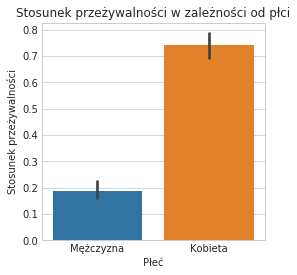

In [281]:
#Plotowanie wykresu z zaleznoscia przyzywalnosci od plci
plt.figure(figsize=(4,4))
sns.set_style("whitegrid")
ax = sns.barplot(x="Sex", y="Survived", data=df_train).set(title = 'Stosunek przeżywalności w zależności od płci',
                                                           xlabel = 'Płeć', ylabel = 'Stosunek przeżywalności',
                                                           xticklabels=['Mężczyzna', 'Kobieta'])

In [282]:
#Zastapienie nazw plci 'male' przez 0, 'female' przez 1
def replace_sex_names_with_code(df):
    df.Sex.replace(['male', 'female'], [0, 1], inplace = True)
    return (df)

for i in [df_all, df_train, df_test]:
    replace_sex_names_with_code(i)

#Inne sposoby zakodowania danych
#df_train['_Sex'] = pd.Categorical(df_train.Sex).codes #utworzenie nowej kolumny z zakodowanymi plciami
#sprawdz get_dummies()
#dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
#df['sex_cat'] = pd.factorize( df['Sex'] )[0]

### Wnioski z kategorii Sex (Płeć)
* Zmienna płeć odgrywała dużą rolę, jeśli chodzi o przeżycie (Survived). Przeżyło ponad 74% kobiet i tylko niewiele ponad 18% mężczyzn.
* Jest to istotna zmienna predykcyjna.
* Wprowadzono encoding, przypisano wartość 0 dla 'male' (mężczyzny) i 1 - 'female' dla kobiety, by modele mogły działać na liczbach


## 2.2 Zmienna Pclass - Klasa, w której podróżował pasażer

Przebieg działania:
* Sprawdzenie czy zmienna ma unikalne wartości, czy trzeba ją zakodować
* Sprawdzenie czy nie ma braków danych
* Sprawdzenie liczby pasażerów z poszczególnych klas
* Sprawdzenie stosunku uratowanych w zależności od przynależności do danej klasy oraz płci (w konsoli oraz na wykresach)


In [283]:
#Sprawdzam wartosci jakim zakodowana jest klasa
print('~~~Unikalne wartosci dla kategorii Pclass~~~')
print(df_all.Pclass.unique())
print('\n')

#Sprawdzam czy nie ma brakujacych danych w zbiorze
print('~~~Ilosc pustych danych w zbiorze~~~')
print(df_all.Pclass.isnull().sum())
print('\n')

#Liczba pasazerow poszczegolnych klas (zbior train)
print('~~~Liczba pasazerow w danej klasie (train)~~~')
print(df_train.Pclass.value_counts())
print('\n')

#Udzial poszczegolnych klas wsrod tych, ktorzy przetrwali
print('~~~Stosunek uratowanych z poszczegolnych klas~~~')
print(df_train.groupby(['Pclass'])['Survived'].mean()*100)
print('\n')

#Udzial poszczegolnych klas wsrod tych, ktorzy przetrwali z uwzglednieniem plci
print('~~~Stosunek uratowanych z poszczegolnych klas z uwzglednieniem plci~~~')
print(df_train.groupby(['Pclass', 'Sex'])['Survived'].mean()*100)
print('\n')

~~~Unikalne wartosci dla kategorii Pclass~~~
[3 1 2]


~~~Ilosc pustych danych w zbiorze~~~
0


~~~Liczba pasazerow w danej klasie (train)~~~
3    491
1    216
2    184
Name: Pclass, dtype: int64


~~~Stosunek uratowanych z poszczegolnych klas~~~
Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64


~~~Stosunek uratowanych z poszczegolnych klas z uwzglednieniem plci~~~
Pclass  Sex
1       0      36.885246
        1      96.808511
2       0      15.740741
        1      92.105263
3       0      13.544669
        1      50.000000
Name: Survived, dtype: float64




[Text(0,0.5,'Stosunek przeżywalności'),
 Text(0.5,0,'Płeć i klasa'),
 Text(0.5,1,'Stosunek przeżywalności w zależności klasy i płci')]

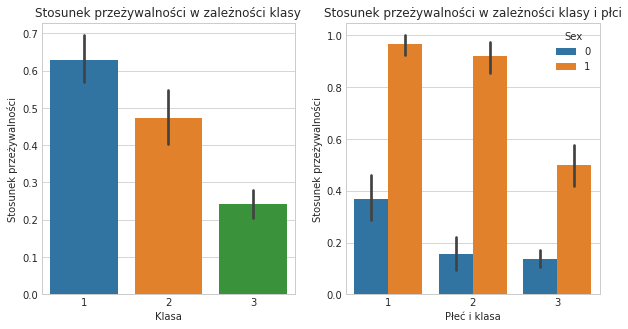

In [284]:
#Plotowanie wykresu z zaleznoscia przyzywalnosci od plci
fig, ax =plt.subplots(1,2, figsize=(10,5))
#fig(figsize=(4,4))
sns.set_style("whitegrid")
sns.barplot(x="Pclass", y="Survived", data=df_train, ax=ax[0]).set(title = 'Stosunek przeżywalności w zależności klasy',
                                                           xlabel = 'Klasa', ylabel = 'Stosunek przeżywalności')
sns.barplot(x="Pclass", y="Survived",hue='Sex', data=df_train, ax=ax[1]).set(title = 'Stosunek przeżywalności w zależności klasy i płci',
                                                           xlabel = 'Płeć i klasa', ylabel = 'Stosunek przeżywalności')
                                                          

### Wnioski z analizy zmiennej Pclass
* Klasa, w której znajdował się pasażer miała znaczny wpływ na szanse uratowania, im wyższa klasa tym większa była szansa (dla zbioru treningowego: 1-klasa 63% przeżyło, 2-klasa 47%, 3-klasa 24%).
* Im wyższa była klasa tym mniej pasażerów się w niej znajdowało (dla zbioru treningowego)
* Im wyższa była klasa tym większe szanse na przeżycie mieli także mężczyźni, ale wśród uratowanych dominowały kobiety (1-klasa - ponad 96% kobiet i 36% mężczyzn uratowanych, 2-klasa 92% uratowanych kobiet i tylko 15% mężczyzn, 3-klasa 50% kobiet i 13% mężczyzn uratowanych)
* Zmienna stanowi ważny predyktor i nie może zostać pominięta.
* W kolumnie Pclass nie było braków danych, a zmienne wyznaczone są przez liczby 1,2,3 i nie były już poddawne encodingowi.

## 2.3 Zmienna Name i pozyskanie Title

### Wstępny przegląd Name (imion i nazwisk)
* Sprawdzenie czy nie ma braków danych
* Czy wartości są unikalne
* Sprawdzenie formy w jakiej występują dane Name

In [285]:
print('~~~Przykladowy wydruk zmiennej Name~~~')
print(df_all.Name.head(4))
print('\n')

#Liczba unikalnych wartosci
print('~~~Liczba unikalnych wartosci dla kategorii Age~~~')
print(df_all.Name.nunique())
print('\n')

#Powtarzajace sie wartosci
print('~~~Powtarzajace sie wartosci~~~')
print(df_all[df_all.Name.duplicated(keep=False)])
print('\n')

#Sprawdzam czy nie ma brakujacych danych w zbiorze
print('~~~Ilosc pustych danych w zbiorze Name~~~')
print(df_all.Name.isnull().sum())
print('\n')

~~~Przykladowy wydruk zmiennej Name~~~
PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
Name: Name, dtype: object


~~~Liczba unikalnych wartosci dla kategorii Age~~~
1307


~~~Powtarzajace sie wartosci~~~
             Survived  Pclass                  Name  Sex   Age  SibSp  Parch  \
PassengerId                                                                    
290               1.0       3  Connolly, Miss. Kate    1  22.0      0      0   
697               0.0       3      Kelly, Mr. James    0  44.0      0      0   
892               NaN       3      Kelly, Mr. James    0  34.5      0      0   
898               NaN       3  Connolly, Miss. Kate    1  30.0      0      0   

             Ticket    Fare Cabin Embarked  
PassengerId                                 
290          370373  7.7500   NaN       

#### Z wstępnego przeglądu zmiennej Name (imion i nazwisk) można wywnioskować, że:
   * nie ma braków w danych
   * tylko 2 imiona i nazwiska się powtarzają, ale są to różne osoby (inny wiek, inny nr biletu)
   * pierwszy człon zmiennej Name to nazwisko, więc można jeszcze sprawdzić ilość osób o takim samym nazwisku, czy to rodzina
   * drugi człon w Name (po przecinku) to tytuł, który może świadczyć o wieku, statusie osoby i wyciągniemy z niego kolejną zmienną (bazując na innych opracowaniach tego datasetu)
    

### Sprawdzenie osób o tym samym nazwisku (być może rodzin)
* Sprawdzenie ile osób ma takie same nazwisko
* Ile jest podzbiorów o konkretnej liczbie osób o takim samym nazwisku
* Ilu z tych podgrup się uratowało
* Jaki był wpływ powtarzalności nazwisk na szanse uratowania


~~~Liczba o tym samym nazwisku (wydruk pierwszych 5)~~~
       _Name  counts
0  andersson       9
1       sage       7
2     panula       6
3     carter       6
4      skoog       6

~~~Liczba osob o takim samym nazwisku | Liczba takich przypadkow~~~
1    534
2     83
3     28
4     14
6      5
9      1
7      1
5      1
Name: counts, dtype: int64

~~~Liczba o tym samym nazwisku | Liczba tych co przetrwali (wydruk pierwszych 5)~~~~~~
           counts  Survived
_Name                      
andersson       9         2
sage            7         0
goodwin         6         0
johnson         6         3
skoog           6         0

~~~Rozmiar grupy o tym samym nazwisku | Wszyscy  | Uratowani | Uratowani w [%]~~~~~~
   All  Survived  Survived [%]
1  534       192     35.955056
2  166        87     52.409639
3   84        30     35.714286
4   56        24     42.857143
5    5         0      0.000000
6   30         7     23.333333
7    7         0      0.000000
9    9         2     22.222222


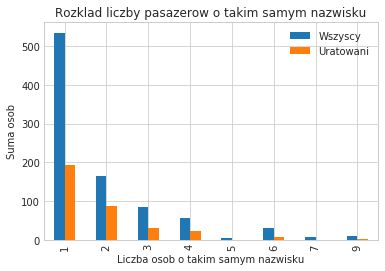

In [286]:
#Ze zbioru wyluskuje nazwiska (pierwszy czlon Name), oraz zapisuje je tylko za pomoca malych liter
#by te same nazwiska nie byly traktowane jako rozne ze wzgledu na wielkosc liter
#Nastepnie obliczam ile osob nosi takie samo nazwisko i drukuje przylad
print('\n~~~Liczba o tym samym nazwisku (wydruk pierwszych 5)~~~')
LastNameSum=df_train['Name'].map(lambda x: x.split(',')[0].lower()).value_counts().reset_index().rename(index=str, columns={"index": "_Name","Name": "counts" })
print(LastNameSum.head(5))

#Tworze nowa kolumne w DF o nazwie _Name, ktora przechowuje nazwiska pasazerow
df_train['_Name']=df_train['Name'].map(lambda x: x.split(',')[0].lower())
df_all['_Name']=df_all['Name'].map(lambda x: x.split(',')[0].lower())

#Sprawdzam ile jest podzbiorow o danej liczbie osob, ktore tworza pseudo-rodzine (maja takie samo nazwisko), 
#ile jest pseudo-rodzin o liczbie czlonkow 9,8,7, etc.
print('\n~~~Liczba osob o takim samym nazwisku | Liczba takich przypadkow~~~')
print(LastNameSum['counts'].value_counts())

#Tworze zestawienie ilosci osob o takim samym nazwisku i ile osob przetrwalo
LastNameSum=LastNameSum.sort_values('_Name').reset_index().set_index('_Name')
LastNameSurvivedSum=df_train.groupby(['_Name'])['Survived'].sum().reset_index()
LastNameSurvivedSum=LastNameSurvivedSum.sort_values('_Name').reset_index().set_index('_Name')
LastNameResult = pd.concat([LastNameSum['counts'], LastNameSurvivedSum['Survived']], axis=1, join_axes=[LastNameSum.index]).sort_values('counts', ascending=False)
print('\n~~~Liczba o tym samym nazwisku | Liczba tych co przetrwali (wydruk pierwszych 5)~~~~~~')
print(LastNameResult.head(5))

#Tworze zestawienie ile osob jest w pozbiorze o danej wielkosci grupy (liczbie osob o tym samym nazwisku), ile z tych osob przetrwalo
SurvivedDependLastNameSizeGroup=LastNameResult.groupby(['counts'])['Survived'].sum()
PeopleNumberDependLastNameSizeGroup=LastNameResult.sort_values('counts')
PeopleNumberDependLastNameSizeGroup=LastNameResult['counts'].value_counts(sort=False)
PeopleNumberDependLastNameSizeGroup=PeopleNumberDependLastNameSizeGroup.index*PeopleNumberDependLastNameSizeGroup
SurvivedPercent=SurvivedDependLastNameSizeGroup/PeopleNumberDependLastNameSizeGroup*100
LastNameResultWithNumbers = pd.concat([PeopleNumberDependLastNameSizeGroup, SurvivedDependLastNameSizeGroup, SurvivedPercent], axis=1, join_axes=[PeopleNumberDependLastNameSizeGroup.index]).rename(index=str, columns={0: "All",1: "Survived [%]" })
print('\n~~~Rozmiar grupy o tym samym nazwisku | Wszyscy  | Uratowani | Uratowani w [%]~~~~~~')
print(LastNameResultWithNumbers)

#Wykres rozkladu ilosci wszystkich pasazerow oraz tych co przetrwali w zaleznosci ile osob mialo takie samo nazwisko
ax=LastNameResultWithNumbers.plot(kind='bar',y=['All', 'Survived'], label=['Wszyscy', 'Uratowani'])
plt.legend()
ax.set_xlabel('Liczba osob o takim samym nazwisku')
ax.set_ylabel('Suma osob')
ax.set_title('Rozklad liczby pasazerow o takim samym nazwisku')
plt.show()

 #### Z przeglądu nazwisk widoczne jest:
* Największy udział pasażerów stanowiły osoby, które miały unikalne nazwisko, nie było na pokładzie nikogo innego o takim samym nazwisku. Być może podróżowały same lub  ich rodzina nosiła inne nazwisko. Wśród nich przetrwało około 36%.
* Największe szanse na przeżycie miały osoby należące do grupy 2-osobowej (52%). Można przypuszczać, że były to małżeństwa, a taki duży  procent uratowanych wynikał ze względu na liczbę uratowanych kobiet.
* Można zauważyć tendencję (z wyjątkiem grupy 6 osobowej), że im większa liczba osób o takim samym nazwisku, tym mniej było takim osób.
* Dalsza analiza i tworzenie nowych zmiennych z nazwisk nie będzie prowadzone, bo wiem należało, by sprawdzić, czy osoby były spokrewnione, a ta niejako zawiera się już w zmiennej SibSig, więc dublowalibyśmy dane, także należałoby sprawdzić płeć, a tu dublowalibyśmy zmienną Sex. Analizę przeprowadzono tylko poglądowo i nie będzie dalej używana zmienna z zestawieniem nazwisk.


### Pozyskanie tytułów (Title) z Name, wykorzystanie paternów
* Pozyskanie tytułów z zmiennej Name
* Obliczenie średniego wieku dla danego tytułu
* Sprawdzenie szans na przeżycie w zależności od tytułu
* Encoding

In [287]:
#Sprawdzenie liczebnosci osob o konkretnym tytule
df_all['_Title']=df_all['Name'].map(lambda x: x.split(', ')[1].split('.')[0].lower() )
print('\n~~~Ilosc osob o danym tytule~~~')
print(df_all['_Title'].value_counts())

#Sprawdzenie rozkladu wieku w zaleznosci od tytuly
print('\n~~~Tytul|Srednia|Mediana|Min|Max wieku w zaleznosci od tytulu~~~')
print(df_all.groupby('_Title')['Age'].agg([np.mean, np.median, np.min, np.max]))

#Agregacja tytulow i ich zakodowanie
popular_titles = ["mr", "miss", "mrs", "master", "dr", "rev"]
df_all['Title'] = df_all['_Title'].map(lambda x: x if x in popular_titles else "other")
df_all['Title_encoded'] = pd.factorize( df_all['Title'] )[0]
print('\n~~~Ilosc osob o danym tytule po agregacji~~~')
print(df_all['Title'].value_counts())

#Rozklad wieku po agregacji, zebranie mediany wieku, by uzupelnic puste pola w wieku
print('\n~~~Tytul|Srednia|Mediana|Min|Max wieku w zaleznosci od tytulu~~~')
print(df_all.groupby('Title')['Age'].agg([np.mean, np.median, np.min, np.max]))
missing_ages=df_all.groupby('Title')['Age'].agg([np.mean, np.median, np.min, np.max]).to_dict()['median']

#Sprawdzenie szans przezycia w zaleznosci od tytulu
print('\n~~~Szansa przezycia w zaleznosci od tytulu~~~')
print(df_all.groupby('Title')['Survived'].agg([np.mean]))

#Alternatywny sposob wyznaczenie tytulow
#pat = r",\s([^ .]+)\.?\s+"
#df_all['Title'] =  df_all['Name'].str.extract(pat,expand=True)[0]
#df_all.groupby('Title')['Title'].count()
#df_all.loc[df_all['Title'].isin(['Mille','Ms','Lady']),'Title'] = 'Miss'
#df_all.loc[df_all['Title'].isin(['Mme','Sir']),'Title'] = 'Mrs'
#df_all.loc[~df_all['Title'].isin(['Miss','Master','Mr','Mrs']),'Title'] = 'Other' # NOT IN
#df_all['_Title'] = pd.Categorical(df_all.Title).codes
#df_all.groupby('Title')['Title'].count()


~~~Ilosc osob o danym tytule~~~
mr              757
miss            260
mrs             197
master           61
dr                8
rev               8
col               4
mlle              2
major             2
ms                2
capt              1
sir               1
mme               1
don               1
dona              1
the countess      1
jonkheer          1
lady              1
Name: _Title, dtype: int64

~~~Tytul|Srednia|Mediana|Min|Max wieku w zaleznosci od tytulu~~~
                   mean  median   amin  amax
_Title                                      
capt          70.000000    70.0  70.00  70.0
col           54.000000    54.5  47.00  60.0
don           40.000000    40.0  40.00  40.0
dona          39.000000    39.0  39.00  39.0
dr            43.571429    49.0  23.00  54.0
jonkheer      38.000000    38.0  38.00  38.0
lady          48.000000    48.0  48.00  48.0
major         48.500000    48.5  45.00  52.0
master         5.482642     4.0   0.33  14.5
miss          21.77

#### Wnioski po analizie tytułów:
* dominujące tytuły to Mr, Miss, Mrs, Master oraz kilka osób z tytułem Rev, Dr i tylko te tytuły uwzględniamy bez zmian, bo pozostałe występują pojedynczo lub po dwa i podlegają agreacji w grupę other
* widoczny jest duży rozrzut w wieku dla większości grup
* Dr - zazwyczaj mężczyzna w sile wieku około 50tki, ale najmłodszy w tej grupie ma tylko 23 lata
* Master - chłopiec, grupa o medianie równej 4 lata, ale najstarszy ma ponad 14 lat, a najmłodszy jest 4 miesięcznym noworodkiem
* Miss - określenie panny (?), ale też jako małej dziewczynki, jak i kobiety w podeszłym wieku, mediana wieku 22lata, ale zakres wieku od noworodka (2 miesiące) do starszej kobiety (63lata)
* Mr - określenie mężczyzny, mediana 29 lat, najmniej 11lat, najwięcej 80lat
* Mrs - określenie kobiety, mediana 35.5 lat, najmniej 14 lat, nawięcej 76
* Rev - osoba w średnim wieku, mediana 41.5, najmniej 27, najwięcej 57'
* Po raz kolejny widoczne, że bycie kobietą gwarantowało dużo większe szanse na przeżycie, bo posiadaczki tytułów Miss oraz Mrs miały odpowiednio prawie 70% oraz ponad 79% szans na przeżycie, duże szanse mieli też mali chłopcy - Master - 58% szans. Najmniej mieli posiadacze tytuły Rev (?) 0% oraz mężczyźni - Master - około 16%
* Dodatko zebrano mediane wieku, dla tytułu, by uzupełnić brakujące informacje o wieku

## 2.4 Zmienna Age - Wiek
### Wstępny przegląd

In [288]:
#Sprawdzam wartosci jakim zakodowana jest klasa
print('~~~Unikalne wartosci dla kategorii Age~~~')
print(df_all.Age.unique())
print('\n')

#Liczba unikalnych wartosci
print('~~~Liczba unikalnych wartosci dla kategorii Age~~~')
print(df_all.Age.nunique())
print('\n')


#Sprawdzam czy nie ma brakujacych danych w zbiorze
print('~~~Ilosc pustych danych w zbiorze Age~~~')
print(df_all.Age.isnull().sum())
print('\n')

#Statystyka opisowa 
print('~~~Statystyka opisowa wieku (Age)~~~')
print(df_all.Age.describe())
print('\n')

~~~Unikalne wartosci dla kategorii Age~~~
[22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.   22.5  18.5  67.   76.   26.5  60.5  11.5
  0.33  0.17 38.5 ]


~~~Liczba unikalnych wartosci dla kategorii Age~~~
98


~~~Ilosc pustych danych w zbiorze Age~~~
263


~~~Statystyka opisowa wieku (Age)~~~
count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64




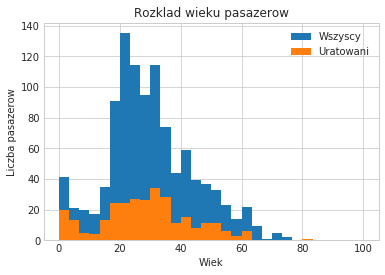

In [289]:
#Wyplotowanie histogramu z podzialem na 30 zakresow
fig, ax=plt.subplots()
plt_all=plt.hist(df_all['Age'],bins = 30,  range = [0,100],label='Wszyscy')
plt_survived=plt.hist(df_all[df_all['Survived']==1]['Age'], bins=30, range=[0,100], label='Uratowani')
plt.legend()
ax.set_xlabel('Wiek')
ax.set_ylabel('Liczba pasazerow')
ax.set_title('Rozklad wieku pasazerow')
plt.show()

### Z wstępnego przeglądu zmiennej Age - wieku:
* widoczne są znaczne braki w miejscach określających wiek, dlatego konieczne będzie uzupełnienie braków.
* wartości wieku wyrażone są jako liczby zmiennoprzecinkowe z dokładnośią do 2 miejsc po przecinku oraz występuje prawie 100 różnorodnych wartości. Taki zbiór nie nadaje się do przeprowadzenia treningu. 
* najliczniejszą grupę stanowiły osoby w wieku 20-40 lat i także śmiertelność w tej grupie była największa
* pojedyncze osoby o wieku powyżej 60 lat, które mogą zaburzać predykcję
* konieczny podział osób na kilka zakodowanych grup wiekowych

### Uzupełnienie braków w wieku
Wykrzystuje mediane wieku dla danego tytułu

In [290]:
#Uzupelniam puste miejsca wiekiem z tytulow
df_all['Age'] = df_all.apply( lambda x: x['Age'] if str(x['Age']) != 'nan' else missing_ages[x['Title']], axis=1 )
print('\n~~~Puste miejsca po imputacji w zmiennej Age~~~')
print(df_all.Age.isnull().sum())


~~~Puste miejsca po imputacji w zmiennej Age~~~
0


### Podzial wieku na mniejsze podbiory i zakodowanie
Dzielę zbiór na przedziały wiekowe:
* 0-3lat
* 3-8lat
* 8-15 lat
* 14-20lat
* 20-40lat
* 40-60lat
* 60-100lat
<br>Następnie robię encoding grup wiekowych


In [291]:
#Podzial wieku na podzbiory do ciecia
age_bins = [0,1, 3, 8, 15, 20,30, 40,60, 100]
df_all['Age_cut']=pd.cut(df_all["Age"], bins=age_bins)

#Ilosc osob w danym przedziale wiekowym
print('\n~~~Ilosc osob w danym przedziale wiekowym~~~')
print(df_all['Age_cut'].value_counts())

#Szansa przezycia od przedzialu wiekowego
print('\n~~~Szansa przezycia w zaleznosci od przedzialu wieku~~~')
print(df_all.groupby('Age_cut')['Survived'].agg(np.mean))

#Encoding grup wiekowych
age_bins = [0,1, 2,3, 5,8,12, 15,18, 20,25,30,35, 40,50,60, 100]
df_all['Age_cut']=pd.cut(df_all["Age"], bins=age_bins)
df_all['Age_encoded'] = pd.factorize( df_all['Age_cut'] )[0]


~~~Ilosc osob w danym przedziale wiekowym~~~
(20, 30]     587
(30, 40]     237
(40, 60]     196
(15, 20]     133
(8, 15]       43
(3, 8]        39
(60, 100]     33
(0, 1]        22
(1, 3]        19
Name: Age_cut, dtype: int64

~~~Szansa przezycia w zaleznosci od przedzialu wieku~~~
Age_cut
(0, 1]       0.857143
(1, 3]       0.500000
(3, 8]       0.642857
(8, 15]      0.448276
(15, 20]     0.343750
(20, 30]     0.311688
(30, 40]     0.482558
(40, 60]     0.387597
(60, 100]    0.227273
Name: Survived, dtype: float64


#### Wnioski z dalszej analizy wieku z podziałem na podzbiory
* największe szanse na przeżycie miały noworodki 0-1, a później dzieci 3-8 lat
* najmniejsze szanse mieli ludzie w sile wieku 20-30lat oraz staruszkowie 60-100lat

## 2.5 Sibsp & Parch – liczba małżonków, lub rodzeństwa na pokładzie oraz liczba dzieci/rodziców na pokładzie posłuży wyznaczenie wielkości rodziny Family_size oraz zmiennej IsAlone
* Na początku sprawdziliśmy, że nie brakuje danych w zmiennych Sibsp oraz Parch, dlatego pominiemy ten pkt
* Z zmiennej Sibsp i Parch tworzymy zmienną Familiy_size informującą o wielkości rodziny bez uwzględnienia samego pasażera
Family_size=Sibsp+Parch


In [292]:
#Utworzenie nowej zmiennej Family_size
df_all['Family_size']=df_all['SibSp']+df_all['Parch']+1

print('\n~~~Wielkosc rodziny | Liczba pasazerow~~~')
print(df_all.Family_size.value_counts())

print('\n~~~Wielkosc rodziny | Szanse na przezycie~~~')
print(df_all.groupby('Family_size')['Survived'].mean())

#Utworzenie zmiennej IsAlone informujacej czy pasazer podrozowal sam
df_all['IsAlone']=df_all.apply(lambda x: 1 if x['Family_size']==1 else 0, axis=1)

print('\n~~~Zaleznosc miedzy podrozowaniem samemu a przezyciem')
print(df_all.groupby('IsAlone')['Survived'].mean())


~~~Wielkosc rodziny | Liczba pasazerow~~~
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64

~~~Wielkosc rodziny | Szanse na przezycie~~~
Family_size
1     0.303538
2     0.552795
3     0.578431
4     0.724138
5     0.200000
6     0.136364
7     0.333333
8     0.000000
11    0.000000
Name: Survived, dtype: float64

~~~Zaleznosc miedzy podrozowaniem samemu a przezyciem
IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64


### Wnioski z przegladu wielkosci rodziny:
* najwięcej osób podróżowało samotnie i miało około 30% szans na przeżycie
* podróżujący rodziną mieli 50% szans na przeżycie


## 2.6 Fare - opłata za bilety
* statyska opisowa cen biletów
* przegląd brakujących danych Fare, opis osoby, dla której brakuje tych informacji
* na podstawie zmiennych Pclass, Age, Embarked ( i osób o podobnych wartościach w tych zmiennych) oszacowanie brakujacej ceny biletu
* histogram z rozkładem cen biletów

In [293]:
print('\n~~~Satystyka opisowa - Fare - Cena biletu~~~')
print(df_all.Fare.describe())

#Wydrukowanie informacji o osobie, ktorej ceny biletu brakuje
print('\n~~~Wiersz, w ktorym brakuje ceny biletu~~~')
print(df_all[df_all.Fare.isnull()][['Name', 'Pclass', 'Age', 'Embarked']])

#Pozyskanie wartosci klasy, zaokretowania i oplaty
#missPclass=df_all.loc[df_all.Fare.isnull(), 'Pclass'].values
#missEmbarked=df_all.loc[df_all.Fare.isnull(), 'Embarked'].values
#missFare_Age=df_all.loc[df_all.Fare.isnull(), 'Age'].values

#Ceny biletow pasazerow o podobnej specyfice to tego, ktorego ceny brakuje
print('\n~~~Sprawdzenie cen biletow pasazerow w podobnym wieku, klasie i zaokretowaniu~~~')
val = df_all[(df_all['Pclass'] == 3)&(df_all['Embarked'] == 'S')&(df_all['Age'] > 60.5)][['Age','Fare']];
print(val.groupby('Age').agg(['min','max','count','mean','median']))

#Obliczenie sredniej ceny biletow dla osob o podobnej specyfice do brakujacej
val_mean=val.groupby('Age').agg(np.mean).mean()
print('\n~~~Srednia cena biletu osob o podobnej specyfice={}'.format(val_mean.values))

#Uzupelnieni pustych miejsc
df_all.loc[df_all.Fare.isnull(),'Fare']=val_mean.values


#Wstawienie danych w konkretnym miejscu
#df_all.at[1044,'Fare']=val_mean.values
#df_all['Fare']=df_all.apply(lambda x: x['Fare'] if str(x['Fare']) != 'nan' else val_mean.values, axis=1 )


~~~Satystyka opisowa - Fare - Cena biletu~~~
count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

~~~Wiersz, w ktorym brakuje ceny biletu~~~
                           Name  Pclass   Age Embarked
PassengerId                                           
1044         Storey, Mr. Thomas       3  60.5        S

~~~Sprawdzenie cen biletow pasazerow w podobnym wieku, klasie i zaokretowaniu~~~
        Fare                              
         min     max count    mean  median
Age                                       
61.0  6.2375  6.2375     1  6.2375  6.2375
63.0  9.5875  9.5875     1  9.5875  9.5875
74.0  7.7750  7.7750     1  7.7750  7.7750

~~~Srednia cena biletu osob o podobnej specyfice=[7.86666667]


### Dalej przyjżymy się zmiennej Fare:
* sprawdzimy rozkład Fare
* zależność między Fare, a innymi zmiennymi
* wpływ wartości Fare na szansę na przetrwanie (Survived)
* przeprowadzimy normalizację zmiennej Fare

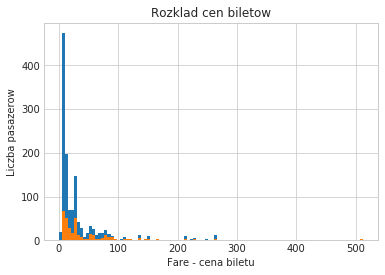

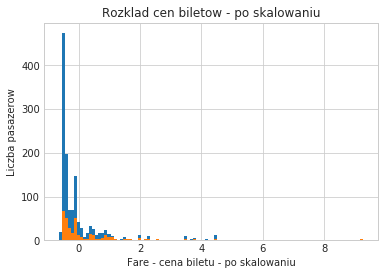


~~~Ilosc osob w danym przedziale ceny biletu Fare~~~
(7, 10]       455
(10, 20]      261
(20, 30]      213
(30, 50]      103
(50, 70]       84
(70, 100]      72
(100, 200]     46
(200, 600]     38
(0, 7]         20
Name: Fare_cut, dtype: int64

~~~Ilosc osob w danym przedziale ceny biletu Fare z uwzgledniem klasy~~~
Fare_cut    Pclass
(0, 7]      3          19
            1           1
(7, 10]     3         454
            2           1
(10, 20]    2         145
            3         116
(20, 30]    2          84
            1          66
            3          63
(30, 50]    1          40
            3          34
            2          29
(50, 70]    1          60
            3          19
            2           5
(70, 100]   1          65
            2           7
(100, 200]  1          46
(200, 600]  1          38
Name: Pclass, dtype: int64

~~~Szansa przezycia w zaleznosci od przedzialu cenowego biletu~~~
Fare_cut    Pclass
(0, 7]      1         0.000000
            3         0.

In [294]:
# Skalowanie Fare
from sklearn import preprocessing
df_all['_Fare'] = preprocessing.scale(df_all[['Fare']])[:,0]
#df_all['_Fare'] = preprocessing.normalize(df_all[['Fare']], norm='l2')

#Wyplotowanie histogramu z Fare przed skalowaniem z podzialem na 100 zakresow
fig, ax=plt.subplots()
plt_all_fare=plt.hist(df_all['Fare'], bins=100)
plt_survived_fare=plt.hist(df_all[df_all['Survived']==1]['Fare'], bins=100)
plt.legend()
ax.set_xlabel('Fare - cena biletu')
ax.set_ylabel('Liczba pasazerow')
ax.set_title('Rozklad cen biletow')
plt.show()

#Wyplotowanie histogramu z Fare po skalowaniu z podzialem na 100 zakresow
fig, ax=plt.subplots()
plt_all_fare=plt.hist(df_all['_Fare'], bins=100)
plt_survived_fare=plt.hist(df_all[df_all['Survived']==1]['_Fare'], bins=100)
plt.legend()
ax.set_xlabel('Fare - cena biletu - po skalowaniu')
ax.set_ylabel('Liczba pasazerow')
ax.set_title('Rozklad cen biletow - po skalowaniu')
plt.show()

#Pociecie na przedzialy, by sprawdzic wplyw ceny biletu na przezycie
fare_bins = [0,7,10, 20, 30, 50, 70,100,200,600]
df_all['Fare_cut']=pd.cut(df_all["Fare"], bins=fare_bins)

#Zakodowanie przedzialow, byc moze poprawia wynik
df_all['_Fare_encoded'] = df_all['Fare_cut'].cat.codes

#Ilosc osob w danym przedziale ceny biletu
print('\n~~~Ilosc osob w danym przedziale ceny biletu Fare~~~')
print(df_all['Fare_cut'].value_counts())

#Ilosc osob w danym przedziale ceny biletu z uwzglednieniem klasy
print('\n~~~Ilosc osob w danym przedziale ceny biletu Fare z uwzgledniem klasy~~~')
print(df_all.groupby('Fare_cut')['Pclass'].value_counts())

#Szansa przezycia od przedzialu cenowego biletu
print('\n~~~Szansa przezycia w zaleznosci od przedzialu cenowego biletu~~~')
print(df_all.groupby(['Fare_cut', 'Pclass'])['Survived'].agg(np.mean))

#### Wnioski z analizy Fare
*  największy udział mają bilety w przedziale ceny 7-10
* mediana ceny biletu wynosi około 14
* 75% biletów zamyka się w cenie 31
* można zauważyć, że tanie bilety 0-10 dominują w klasie 3, 10-20 to przedział przejściowy między 3 a 2-gą klasą, a powyżej 30 dominują bilety w pierwszej klasie, przy czym pojawiają się pojedyncze przypadki z 3-klasy, być może są to jakieś bilety grupowe
* najmniejsze szanse na przetrwanie niosło posiadanie biletu w zakresie 0-10, a powyżej Fare=70 szanse wzrastały pożej 70% (przy założeniu, że podróżowało się w 1-szej klasie
* utworzono 2 dodatkowe zmienne [  __ Fare] - zawierającą przeskalowane wartości Fare oraz zmienną [_Fare_encoded] zawierającą zakodowane wartości przedziałów Fare, by duże wartości Fare nie wpływały negatywnie na proces treningu


## 2.7 Cabin - nr kabiny
* zmienna Cabin posiada znaczne braki danych
* przeprowadzimy proces zastąpienie pustych miejsc zmienną = 'missing'
* oraz dodatkowo wyciągniemy pierwszą literę z nazwy kabiny, bo może ona definiować położenie na statku
* sprawdzimy jaka jest zależność między nazwą kabiny

In [295]:
print('\n~~~Przykladowy wydruk informacji o Cabin~~~')
print(df_all.Cabin.sample(4))

#Uzyskanie tylko typow kabin (pierwsz litera) + brakujace nazwane jako missing
df_all['_Cabin'] =df_all.Cabin.astype(str).str[0]
df_all.loc[df_all._Cabin=='n', '_Cabin']='missing'

print('\n~~~Zestawienie typow Cabin (pierwsza litera)')
print(df_all._Cabin.value_counts())

print('\n~~~Zestawienie typow Cabin i klas')
print(df_all.groupby('_Cabin')['Pclass'].value_counts())

#Zakodowanie typow kabin
df_all['_Cabin_encoded']=pd.Categorical(df_all['_Cabin']).codes


~~~Przykladowy wydruk informacji o Cabin~~~
PassengerId
1026    NaN
523     NaN
361     NaN
203     NaN
Name: Cabin, dtype: object

~~~Zestawienie typow Cabin (pierwsza litera)
missing    1014
C            94
B            65
D            46
E            41
A            22
F            21
G             5
T             1
Name: _Cabin, dtype: int64

~~~Zestawienie typow Cabin i klas
_Cabin   Pclass
A        1          22
B        1          65
C        1          94
D        1          40
         2           6
E        1          34
         2           4
         3           3
F        2          13
         3           8
G        3           5
T        1           1
missing  3         693
         2         254
         1          67
Name: Pclass, dtype: int64


#### Wnioski z analizy zmiennej Cabin
* Nazwy kabin w większości posiadają osoby z pierwszej klasy
* Brakuje danych o kabinie głównie dla 3 klasy
* Zmienna _Cabin_encoded zawiera zakodowane grupy kabin

## 2.8 Zmienna Embarked - zaokrętowanie
* sprawdzenie brakujących danych
* uzupełnienie brakujących danych, bazująć na podobnych pasażerach
* sprawdzenie zależności między portem, a klasą, ceną biletu i szansami na przeżycie
* zakodowanie zmiennych

In [296]:
#Sprawdzam dla jakich wierszy brakuje danych
print('\n~~~Dla jakich wierszy brakuje zmiennej Embarked~~~')
print(df_all[df_all.Embarked.isnull()][['Name', 'Fare', 'Pclass', 'Ticket']])

#Jakie zaokretowanie maja osoby o tym samym typie kabiny i podobnej cenie biletu
print('\n~~~Jakie zaokretowanie maja osoby o tym samym typie kabiny i podobnej cenie biletu')
print(df_all[(df_all['_Cabin']=='B')&(df_all['Fare']>79)]['Embarked'].value_counts())

print('\n~~~Ilosc pasazerow z konkretnych portow z podzialem na klasy')
print(df_all.groupby('Embarked')['Pclass'].value_counts())

print('\n~~~Zestawienie portow zaokretowania, klasy i mediany ceny biletu~~~')
print(df_all.groupby(['Embarked','Pclass'])['Fare'].median())

print('\n~~~Zestawienie portow zaokretowania i szans na przezycie~~~')
print(df_all.groupby(['Embarked'])['Survived'].mean())

print('\n~~~Zestawienie portow zaokretowania i pasazerow w konkretnych typach kabin')
print(df_all.groupby(['Embarked'])['_Cabin'].value_counts())

#Zakodowanie zmiennej Embarked - portow za pomoca int-ow
df_all['_Embarked_encoded']=pd.Categorical(df_all['Embarked']).codes



~~~Dla jakich wierszy brakuje zmiennej Embarked~~~
                                                  Name  Fare  Pclass  Ticket
PassengerId                                                                 
62                                 Icard, Miss. Amelie  80.0       1  113572
830          Stone, Mrs. George Nelson (Martha Evelyn)  80.0       1  113572

~~~Jakie zaokretowanie maja osoby o tym samym typie kabiny i podobnej cenie biletu
C    21
S    16
Name: Embarked, dtype: int64

~~~Ilosc pasazerow z konkretnych portow z podzialem na klasy
Embarked  Pclass
C         1         141
          3         101
          2          28
Q         3         113
          2           7
          1           3
S         3         495
          2         242
          1         177
Name: Pclass, dtype: int64

~~~Zestawienie portow zaokretowania, klasy i mediany ceny biletu~~~
Embarked  Pclass
C         1         76.7292
          2         15.3146
          3          7.8958
Q         1        

#### Wnioski z zmienej Embarked - zaokretowania
* najwięcej pasażerów zaokrętowano w porcie S i byli to pasażerowie głównie 3 klasy, z brakującymi informacjami o kabinie
* w porcie Q zaokrętowano najmniej pasażerów, głównie 3 klasa, znów braki w informacji o kabinach
* w porcie C największy udział pasażerów stanowią posiadacze biletu na pierwszą klasę, ale też jest sporo osób z klasy 3, bez informacji o kabinach
* mediana cen biletów jest podobna dla klasy 2 i 3 we wszystkich portach i oscyluje 12-15 dolarow dla klasy 2 i około 8 dla klasy 3, dla klasy 1 ta wartość ma większą rozbieżność od około 50-90 dolarów, ale może to wynikać z niewielkiej liczby pasażerów pierwszej klasy w portcie Q
* największe szanse na przeżycie mieli zaokrętowni w porcie C, co może wynikać, z tego że to pasażerowie głównie 1-szej klasy
* dla portów Q i S wartości szans na przeżycie oscylują między 33-38%


Wydaje się, że zmienna Embarked nie wniesie nowych zależności i nie wpłynie znacznie na poprawę wyniku predykcji szans na przeżycie.

## 2.9 Ticket - nr biletu
* Sprawdzenie  przykładowych biletów
* Sprawdzenie unikalnej liczby biletów
* Wprowadznie nowej zmiennej, która zawiera informacje ile osób jeszcze posiada taki sam nr biletu (_TicketCounts)

In [297]:
print('\n~~~Przykladowe numery biletow~~~')
print(df_all.Ticket.sample(5))

print('\n~~~Liczba unikalnych nr biletow~~~')
print(df_all.Ticket.nunique())

#Zmienna ile osob ma taki sam nr biletu
df_all['_TicketCounts'] = df_all.groupby(['Ticket'])['Ticket'].transform('count')


~~~Przykladowe numery biletow~~~
PassengerId
571     S.W./PP 752
191          234604
1154          29103
736           54636
344          244361
Name: Ticket, dtype: object

~~~Liczba unikalnych nr biletow~~~
929


#### Wnioski z analizy Ticket:
* większość pasażerów posiadała unikalny bilet (tylko oni byli do niego przypisani)
* utworzono pomocniczą zmienną _TicketCounts, która zawiera informacje, kto jeszcze podróżował na takim samym bilecie, a więc świadczy to , że taka osoba nie podróżowała sama


# 3 Sprawdzenie korelacji między zmiennymi


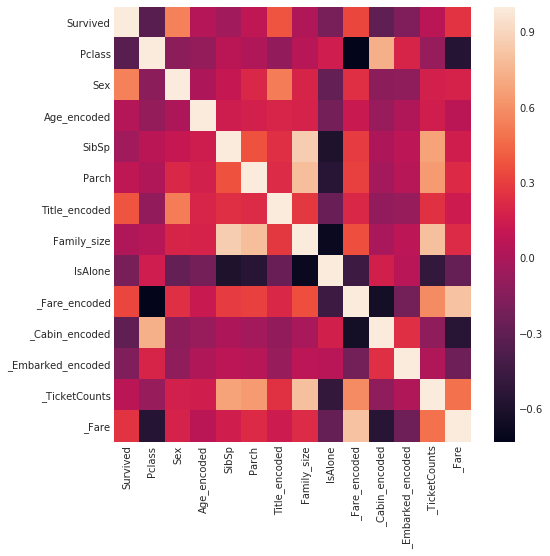

In [298]:
#Wybranie kolumn, ktore beda uzyte do treningu
columns_names=['Survived', 'Pclass', 'Sex', 'Age_encoded', 'SibSp', 'Parch', 'Title_encoded', 'Family_size','IsAlone','_Fare_encoded','_Cabin_encoded', '_Embarked_encoded', '_TicketCounts', '_Fare' ]

#Sprawdzenie korelacji miedzy zmiennymi
corr = df_all[columns_names].corr()
#print(corr)

#Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr)

#### Wnioski z heatmapy i korelacji
* widoczne są zależności, które zostały ujawnione już podczas podczas obróbki zmiennych
* wpływ klasy, ceny bilety, płci, tytułem na zwiększenie szans na przeżycie (wyższa klasa, wyższa cena, kobieta, tytuł związany z kobietą -> większe szanse na przetrwanie)
* związek między ceną biletu a klasą (wyższa klasa->wyższa cena)
* zależności, że podróżowanie samemu niosło ze sobą większe ryzko śmierci
* pozytywna korelacja między ilością podróżnych na jeden bilet, a jego ceną (wyższa cena za więcej osób 0->logiczne)
* oraz korelacje między zmiennymi i ich nowo utworzonymi pochodnymi (np. wielkość rodziny od ilości dzieci, małżonów, braci etc)



# 4. Wstępna budowa modelu

## 4.1 Wstępna predykcja, wybranie modelu do dalszej optymalizacji
* Wybranie i import wstępnych modeli ML do klasyfikacji
* Wybranie zmiennych do predykcji
* Wydzielenie zbioru treningowego, podział na zbiór zmiennych predykcyjnych X oraz zmienną przewidywaną Y
* Przeprowadzenie cross-validation, dla różnych modeli, zbadanie wyniku testowego dla różnych modeli, krzywe treningowe
* Wybranie modelu do dalszej analizy


### 4.1.1 Wybranie i import różnych modeli ML do klasyfikacji
* import modeli Logistycznej Regresji,Naive Bayesian, Support Vector Machine do klasyfikacji,  drzewo decyzyjne, las losowy, ,sieci neuronowe,  k-najbliżych sąsiadów, XGBoost
* utworzenie słównika z różnymi modelami

In [299]:
#Import roznych modeli ML do testow
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import linear_model
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

#Zebranie estymatow w jednym dictionarze
classifiers = {
    'LogisticRegression':  linear_model.LogisticRegression(),
    'SVC': SVC(class_weight='balanced'),
    'LinearSVC':  LinearSVC(),
    'GaussianNB': GaussianNB(),
    'XGBoost': XGBClassifier(),#max_depth=3, n_estimators=15, subsample=0.8, random_state=2018),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),#(n_estimators=100),
    'KNeighbours': KNeighborsClassifier(),
    'NeuralNetwork': MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
}

### 4.1.2 Wybranie zmiennych, które będą użyte do wstępnego treningu oraz wydzielenie zbioru treningowego
* wybrane zmienna do wstępnego treningu: Pclass - klasa, Sex - zakodowana płeć (0,1), Age_encoded - zakodowany wiek, Family_size (zakodowany rozmiar rodziny),  _Fare - przeskalowana wartość ceny biletu, Title_encoded - zakodowany tytuł, IsAlone - czy osoba podróżuje sama (0,1), pozostałe kolumny wstępnie odrzucono, bo zaniżały wynik zarówno podczas wstępnej CV jak i podczas submitu wyniku do rankingu głównego
* wydzielenie zbioru treningowego z DataFrame zawierającego zbiór treningowu i testowy, które zostały złączone na początku analizy (dataset treningowy zawierał wartość w kolumnie Survived i liczył SURV=891 wierszy, natomiast zbiór testowy nie zawierał tej danej i znajdował się poniżej wiersza 891)
* podzielenie zbioru na zmienne predykcyjne X z wybranymi zmiennymi oraz zbiór, którego wartość przewidujemy Y zawierający kolumnę Survived

In [300]:
#Wybranie kolumn, ktore beda uzyte do wstepnych obliczen
cols=['Pclass', 'Sex', 'Age_encoded', 'Family_size','_Fare', 'Title_encoded']#, 'IsAlone']#'_Fare_encoded']#,'_Cabin_encoded']

#Wydzielenie zbioru treningowego z polaczonego datasetu
def get_train_data(df_all, cols):
    SURV = 891
    X = df_all[:SURV][cols] 
    Y = df_all[:SURV]['Survived']
    return X,Y

X,Y=get_train_data(df_all, cols)

### 4.1.3 Definicja modułów i funkcji do treningu i cross-validation
* Definicja funkcji plot_learning_curve, która odpowiedzialna jest za trening i cross-validation dla różnych rozmiarów zbioru treningowego i wyplotowanie krzywych treningowych i krzywych cross-validation oraz uśrednione wyniki testu
* Funkcja będzie użyta, by wybrać najlepszy model do dalszych modyfikacji 

In [301]:
#Chwilowe wylaczenie warningow, zeby nie zaburzaly widoku wykresow
import warnings
warnings.filterwarnings('ignore')

#Import learning_curve, ktora pozwala na cross-validation (zwraca wyniki dla treningu, 
#testu dla roznych zbiorow treningowych i testowych) z dodatkowym uwzglednieniem rozmiaru zbioru treningowego
from sklearn.model_selection import learning_curve

#Import ShuffleSplit, ktory umozliwa losowe wybranie zbioru treningowego i walidacyjny do CV, z uwzgledniem
#rozmiaru zbioru walidacyjnego
from sklearn.model_selection import ShuffleSplit

#Funkcja plot_learning_curve odpowiedzialna jest za wyplotowanie wykresow
#krzywej treningowej oraz krzywej walidacyjnej, wykorzystujac learning_curves,
#pokazuje jak zmienia sie wynik treningu i CV w zaleznosci od rozmiaru zbioru
#treningowego, dodatkowo dodany, by zwracala wartosc srednia wyniku dla CV
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), plot=True):
    
    '''Generate a simple plot of the test and training learning'''
    if plot==True:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    if plot==True:
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
    return plt, test_scores_mean

### 4.1.4 Przeprowadzenie cross-validation z różnym rozmiarem zbioru treningowego dla różnych modeli
* CV dla różnych rozmiarów zbioru treningowe z użycie plot_learning_curves
* przetestowanie różnych modeli klasyfikacyjnych
* porównanie wykresów krzywych treningowych i CV dla różnych modeli
* porównanie wyników uśrednionego wyniku testu z kilku CV dla różnych modeli
* wybór modelu do dalszego tuningu

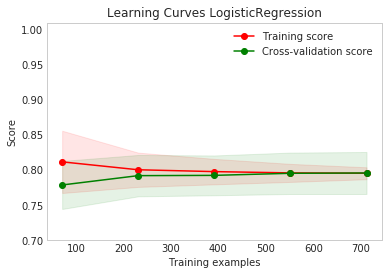

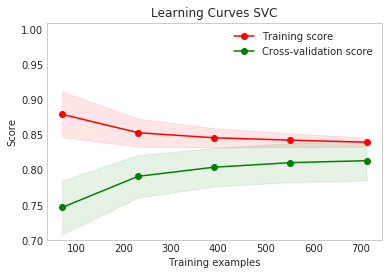

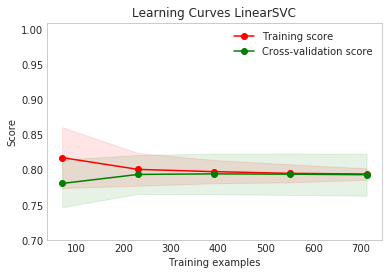

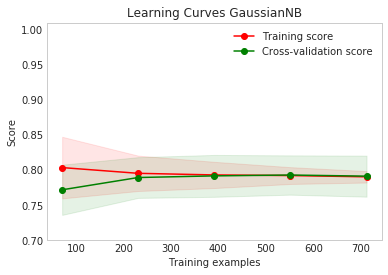

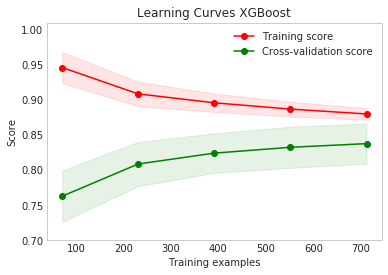

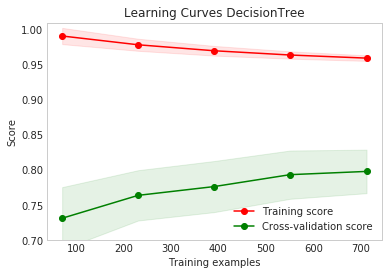

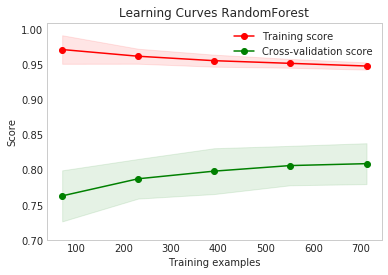

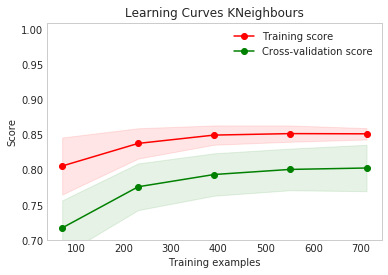

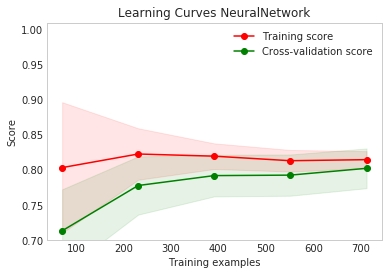


~~~Usrednione wyniki testu dla roznych modeli, z uwzgledniem wielkosci zbioru treningowego do 20% do 100% oraz srednia dla wszystkich treningow~~~


,20_Train,40_Train,60_Train,80_Train,100_Train,Mean
LogisticRegression,0.778883,0.792179,0.792570,0.795531,0.795978,0.791028
SVC,0.746872,0.791229,0.804190,0.810670,0.813520,0.793296
LinearSVC,0.781061,0.793911,0.794693,0.794246,0.793520,0.791486
GaussianNB,0.772011,0.789497,0.791844,0.793073,0.791453,0.787575
XGBoost,0.762849,0.808771,0.824246,0.832570,0.837821,0.813251
DecisionTree,0.731453,0.764078,0.776592,0.793575,0.798212,0.772782
RandomForest,0.763352,0.787709,0.798603,0.806536,0.809274,0.793095
KNeighbours,0.717654,0.776313,0.793799,0.801061,0.803073,0.778380
NeuralNetwork,0.713575,0.778101,0.792235,0.792905,0.802626,0.775888


In [302]:
def test_models(classifiers, X, Y, plot=True):
    '''Funkcja jako argument przyjmuje rodzaj modelu w slowniku, zbior X oraz zbior Y'''
    test_score={} #przechowuje usrednione wyniki CV dla roznych modeli
    for c in classifiers:
        title = "Learning Curves " + c 
        cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0) #CV 100 iteracji z 20% losowym zbiorem testowym
        estimator = classifiers[c] 
        ax, test_score[c] = plot_learning_curve(estimator, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4, plot=plot)
        if plot==True:
            plt.show()
    print('\n~~~Usrednione wyniki testu dla roznych modeli, z uwzgledniem wielkosci zbioru treningowego do 20% do 100% oraz srednia dla wszystkich treningow~~~')
    df_scores=pd.DataFrame.from_dict(test_score).T.rename(index=str, columns={0: '20_Train', 1: '40_Train', 2: '60_Train', 3: '80_Train', 4: '100_Train'})
    df_scores['Mean']=df_scores.mean(numeric_only=True, axis=1)
    df_scores
    return df_scores

test_models(classifiers,X, Y)

### 4.1.5 Wnioski z powyższego punktu i wybór modelu
* widoczny znaczny overfitting (przetrenowanie, high variance) dla dla drzewa decyzyjnego i lasu losowego ( znaczna rozbieżność między wynikiem dla treningu i CV)
* widoczny underfitting (high bias) dla prostych modeli (Regresji Logistycznej (logistic regression), Liniowego SVM (Linear SVC), Naiwnego Bayesiana z rozkładem Gaussa (GausianNB) i sieci neuronowych (neural networks))
* ciekawie wynik daje K-najbliższych sąsiadów, wydaje się, że jeśli dostępny byłby większy zbiór to mógłby osiągnąć lepszy wynik, jednak dla tego daje około accuracy około 0.8
* godne uwagi po przyjżeniu się są 2 algorytmy - SVC oraz XGBoost, przy czym w każdym przypadku rozmiaru zbioru treningowego XGBoost uzyskiwał wyższe accuracy oraz jest zwycięskim algorytmem wielku konkurencji na Kaggle, dlatego do dalszej analizy wybierzemy ten algorytm

# 5. Features Importance - wybór zmiennych do dalszych analiz
* w punkcie 4. przeprowadziliśmy analizę na wybranych kolumnach, których wybór dokonano metodą prób i błędów, teraz jednak dokładnie przyjżymy się wpływowi poszczególnych zmiennych na wynik w XGBoostcie
* dokonamy wyboru, które zmienne będziemy dalej wykorzystywać

### 5.1 Załadowanie zbioru z wszystkimi zmiennymi, które mogą być użyte do analizy

In [303]:
#Wszystkie utworzone, zmodyfikowane, zeskalowane, zakodowane lub pierwotne kolumny(, ktore zawieraja tylko liczby calkowite)
cols_all=['Pclass', 'Sex', 'Age_encoded', 'Family_size',
          '_Fare', 'Title_encoded' ,'_Cabin_encoded','_Embarked_encoded',
          '_TicketCounts', 'SibSp', 'Parch','IsAlone','_Fare_encoded']

#Wydzielenie zbioru treningowego z polaczonego datasetu
X,Y=get_train_data(df_all, cols_all)

#Wynik XGBoosta dla wszystkich kolumn
xgb_clas={'XGBoost': XGBClassifier(),}
test_models(xgb_clas, X, Y, plot=False)



~~~Usrednione wyniki testu dla roznych modeli, z uwzgledniem wielkosci zbioru treningowego do 20% do 100% oraz srednia dla wszystkich treningow~~~


,20_Train,40_Train,60_Train,80_Train,100_Train,Mean
XGBoost,0.76162,0.806536,0.820168,0.829665,0.834022,0.810402


### 5.2 Wykres wpływu zmiennych na wynik (Feature Importance)

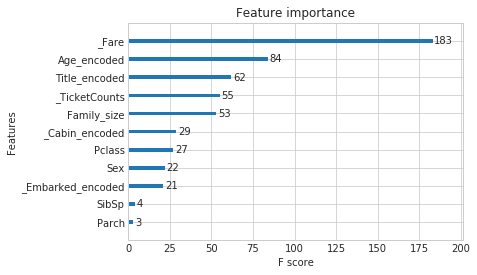

In [304]:
#Plot Feature Importance korzystajac z wbudowanych funkcji XGBoosta
from numpy import loadtxt
from xgboost import plot_importance

# fit na danych
model = XGBClassifier()
model.fit(X, Y)

# plot feature importance
plot_importance(model)
plt.show()



#### Wnioski z powyższego wykresu:
* Zmienne, które zależą od innych mają niewielke znaczenie i można je wyrzucić
* Są to SibSp, Parch, IsAlone, które zależą od Family_Size oraz Fare_encoded, które zależy od Fare
* Największy udział w Feature Importance mają po kolei: Fare, Age_encoded, Title_encoded, Ticet_Counts, Family_size, a więc zmienne, który wartości wahają od -1 do około 10, więc należy sprawdzić, czy nie zaburzają one wyniku przez to, że nie są 0-1


### 5.3 Wpływ parametrów na accuracy
* Odrzucam zmienne SibSp, Parch, IsAlone, oraz Fare_encoded, które nie mają mały wpływ na wynik
* Sprawdzamy, jak uzwględnienie kolejnych zmiennych/ cech wg Feature Importance wpływa na wynik accuracy
* 

In [305]:
#Wszystkie utworzone, zmodyfikowane, zeskalowane, zakodowane lub pierwotne kolumny(, ktore zawieraja tylko liczby calkowite)
cols_cut1=['Pclass', 'Sex',  'Family_size',
          '_Fare', 'Title_encoded' ,'_Embarked_encoded'
          ,'_Cabin_encoded','Age_encoded','_TicketCounts']

#Wydzielenie zbioru treningowego z polaczonego datasetu
X,Y=get_train_data(df_all, cols_cut1)

In [306]:
#Na podstawie https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
#Zadaniem jest:
#wyznaczenie feature importance
#a potem z uzyciem SelectFromModel ze zbioru wybieramy zmienne, ktore sa uzyte do obliczenia accuracy
#zaczynamy od jednej zmiennej z najwyzszym feature importance, a potem dwie zmienne, 3 zmienne i tak az uzwglednimy wszystkie
#sprawdzamy jak uwzglednienie kolejnych zmiennych wplywa na accuracy zbiorcze

from numpy import sort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

# podzial na train i test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# fit na train
model = XGBClassifier()
model.fit(X_train, y_train)

#Drukowanie feature importance wraz z nazwami cech, po sortowaniu, by wiedziec dla czego drukowane sa accuracy
feature_importance_with_names=zip(X.columns,model.feature_importances_)
print('\n~~~Posortowane feature importance od najwiekszego do najmniejszego~~~\n')
print(sorted(feature_importance_with_names, key=lambda x: x[1], reverse=True))
print ('\n')

# predykcja i wydruk accuracy
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)

print('\n~~~Accuracy z uwzglednieniem wszystkich zmiennych~~~\n')
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('\n~~~Wynik accuracy w zaleznosci od ilosci uwzglednionych zmiennych~~~\n')

# posortowanie wg wartosci feture importance
thresholds = sort(model.feature_importances_)

for thresh in thresholds:
    
    
    #wybor zmiennych, ktore feature importance jest wyzszy niz threshold
    #czyli zaczyna od najwiekszej wartosci, ktora spelnia 1 zmienna (_Fare)
    #potem mniejszy threshold, ktory spelniaja juz 2 zmienne (_Fare i Age_encode)
    #itd. az uwzgledni wszystkie zmienne
    #wiec najpierw do obliczen accuracy wykorzystuje 1 zmienna, potem 2,..., a na koniec wszystkie
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    
    #print
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("FeatImportance=%.3f, FeatNumber=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

 

xgb_clas={'XGBoost': XGBClassifier()}
test_models(xgb_clas, X, Y, plot=False)
    


~~~Posortowane feature importance od najwiekszego do najmniejszego~~~

[('_Fare', 0.34470376), ('Age_encoded', 0.1561939), ('Title_encoded', 0.10771993), ('_TicketCounts', 0.10771993), ('_Cabin_encoded', 0.07540395), ('Family_size', 0.062836625), ('_Embarked_encoded', 0.05745063), ('Pclass', 0.05206463), ('Sex', 0.035906643)]



~~~Accuracy z uwzglednieniem wszystkich zmiennych~~~

Accuracy: 80.45%

~~~Wynik accuracy w zaleznosci od ilosci uwzglednionych zmiennych~~~

FeatImportance=0.036, FeatNumber=9, Accuracy: 80.45%
FeatImportance=0.052, FeatNumber=8, Accuracy: 79.89%
FeatImportance=0.057, FeatNumber=7, Accuracy: 77.65%
FeatImportance=0.063, FeatNumber=6, Accuracy: 76.54%
FeatImportance=0.075, FeatNumber=5, Accuracy: 77.09%
FeatImportance=0.108, FeatNumber=4, Accuracy: 77.09%
FeatImportance=0.108, FeatNumber=4, Accuracy: 77.09%
FeatImportance=0.156, FeatNumber=2, Accuracy: 72.63%
FeatImportance=0.345, FeatNumber=1, Accuracy: 74.86%

~~~Usrednione wyniki testu dla roznych modeli, z

,20_Train,40_Train,60_Train,80_Train,100_Train,Mean
XGBoost,0.761955,0.809106,0.822346,0.830615,0.835251,0.811855


### Wnioski z wstępnego przeglądu Feature Importance:
* Odrzucenie zmiennych o niewielkiej wartości Feature Importance przyczyniło się do niewielkiego wzrostu accuracy
* Przegląd wpływu ilości uwzględnionych cech na accuracy nie daje odpowiedzi, które cechy zmodyfikować, bo np.: uwzględniene oprócz Fare także Age_encoded, powoduje spadek accuracy (przy uwzględnieniu tylko tych 2 cech), ale nie uwzględnienie Age_encoded powoduje znaczny spadek całkowitego accuracy
* Przyjżymy się wpływowi pojedynczych cech (z pominięciem pozostałych) na accuracy

## 5.4 Wpływ pojedynczych zmiennych na accuracy (z pominięciem pozostałych)
* użyjemy najprostszej metody, a więc przywidywania z uwzględnieniem tylko 1 kolumny
* przeprowadzimy CV i sprawdzimy accuracy, gdy uwzgledniamy do przewidywnia, tylko konkretna zmienna


In [307]:
from sklearn.model_selection import train_test_split
from operator import itemgetter
from sklearn.model_selection import cross_val_score

#Obliczenie accuracy przy uwzglednieniu tylko 1 zmiennej
def get_accuracy_for_one_feature(df_all, cols_cut1):
    score = {}
    model=XGBClassifier()
    for i in range(0,len(cols_cut1),1):
        cols_cut2=[cols_cut1[i]]
        X,Y=get_train_data(df_all, cols_cut2)    
        score[cols_cut2[0]]=cross_val_score(model, X, Y, cv=5).mean()


    #posortowanie od najwiekszego accuracy do najmniejszego
    print('\n~~~Accuracy przy uwzglednieniu tylko jednej zmiennej~~~')
    return sorted(score.items(), key=itemgetter(1))[::-1]
    

get_accuracy_for_one_feature(df_all, cols_cut1)


~~~Accuracy przy uwzglednieniu tylko jednej zmiennej~~~


[('Title_encoded', 0.7878764247086749),
 ('Sex', 0.7867150249291879),
 ('_Fare', 0.7038825272972746),
 ('_Cabin_encoded', 0.6880953419531334),
 ('_TicketCounts', 0.6712095275281431),
 ('Family_size', 0.667945734908346),
 ('Pclass', 0.6657489023107065),
 ('_Embarked_encoded', 0.6387002280668717),
 ('Age_encoded', 0.6262394641864792)]

### Wnioski z uwzglednienia tylko pojedynczych zmiennych
* Najlepiej z przewidywanie radzą sobie zmienne Title_encoded oraz Sex
* Pomimo, że _Fare miało wysokie wartości Feature Importance przewiduje tylko w 3 co do kolejności dokładnością, a wartość feature importance tej zmiennej może wynikać z dużych wartości, które przyjmuje -> można znormalizować w 0-1 dodatkowo
* Zaskakująco dobrze przewiduje zmienna Cabin_encoded, ale może spowodowane znaczną ilością brakujących danych
* Kiepsko wypada Age_encoded, być może przyjęte przedziały nie są zbyt dobre


## 5.5 Ponowna normalizacja Fare
* normalizacja Fare w zakresie 0-1, by sprawdzić jaki wpływ na uzyskiwany wynik miał jej brak

In [308]:
#Normalizacja Fare w 0-1
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

x = df_all['Fare'].values #returns a numpy array
x=x.reshape(df_all.shape[0],1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_all['_Fare_norm'] = pd.DataFrame(x_scaled)

In [309]:
#Sprawdzenie wyniku accuracy dla pojedynczej zmiennej
col_cut_with_fare=cols_cut1.copy()
col_cut_with_fare.append('_Fare_norm')
get_accuracy_for_one_feature(df_all, col_cut_with_fare)


~~~Accuracy przy uwzglednieniu tylko jednej zmiennej~~~


[('Title_encoded', 0.7878764247086749),
 ('Sex', 0.7867150249291879),
 ('_Fare', 0.7038825272972746),
 ('_Cabin_encoded', 0.6880953419531334),
 ('_TicketCounts', 0.6712095275281431),
 ('Family_size', 0.667945734908346),
 ('Pclass', 0.6657489023107065),
 ('_Embarked_encoded', 0.6387002280668717),
 ('Age_encoded', 0.6262394641864792),
 ('_Fare_norm', 0.6015641606972443)]

### Wnioski po normalizacji Fare
* Uzyskane wyniki są gorsze niż bez normalizacji
* Wstępnie zawieszamy pomysł Feature Enginneringu i sprawdzamy jak na wynik możemy wpłyną tuningiem modelu XGBoost
* Do dalszej analizy i tuningu XGBoosta pozostawiono zmienne:

In [310]:
print('\n~~~Zmienne pozostawione do dalszego tuningu XGBoosta:~~~\n')
print(cols_cut1)


~~~Zmienne pozostawione do dalszego tuningu XGBoosta:~~~

['Pclass', 'Sex', 'Family_size', '_Fare', 'Title_encoded', '_Embarked_encoded', '_Cabin_encoded', 'Age_encoded', '_TicketCounts']


## 6. Tuning XGBoosta
Z użyciem GridSearchCV testujemy:
*  różne maksymalne głębkości drzewa (max_depth)
* różną ilość drzew (n_estimators)
* różną min_child_weight

In [311]:
from sklearn.model_selection import GridSearchCV

#zastosowanie tylko ponizszych 5 zmiennych zapewnia wynik na poziomie 0.7894
#cols_cut12=['Pclass', 'Sex', 'Age_encoded', 'Family_size','_Fare']

cols_cut12=cols_cut1
X, Y = get_train_data(df_all, cols_cut12)

#Parametry do sprawdzenia i wybrania najlepszych
cv_params = {'max_depth': [2,3,4,5],
             'n_estimators': range(10,210,50),
            'learning_rate': [0.01,0.02,0.05,0.07,0.1]}

#parametry podane do XGBoosta
#ind_params = {'learning_rate': 0.05, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
#             'objective': 'binary:logistic'}

xgb= XGBClassifier().fit(X, Y)
optimized_xgb = GridSearchCV(xgb, cv_params, scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_xgb.fit(X, Y)
print('\n~~~Accuracy po optymalizacji~~~\n')
optimized_xgb.score(X,Y)


~~~Accuracy po optymalizacji~~~



0.9079685746352413

### Utworzenie pliku z predykcją do submitu

In [312]:
#Predykcja dla wyniku testowego i submit
#Wyznaczenie zbioru testowego
SURV = 891
Xp = df_all[SURV:][cols_cut12]

#Utworzenie pliku wynikowego
result = pd.DataFrame({'PassengerID': df_all[SURV:].index })
result['Survived'] = optimized_xgb.predict(Xp).T.astype(int)
result[['PassengerID','Survived']].to_csv('submission.csv',index=False)

### Wnioski z tuningu XGBoosta
* XGBoost pomimo wyniku około 90% dla zbioru testowego przewiduje około 76-77% -> overfitting
* Pomimo użycia GridSeachCV nie udało się uzyskać dobrego wyniku, niezbędne jest głębsze zagłębienie się w parametry XGBoosta, bo różnica między zastosowaniem optymalizacji, a jej brak to zaledwie 1% różnicy
* Jednocześnie zastosowanie tylko 5 zmiennych: Pclass, Sex, Age_encoded, Family_size oraz _Fare zapewniło wynik na poziomie 78.94%, co zapewnia około miejsce w top3000 z hakiem
* Zatem błąd nadal tkwi w zmiennych, ale na tym zakończymy ten wstępny projekt

# 7. Wnioski
1. Udało się uzyskać model z accuracy 0.77, przy uwzględnieniu wybranych w punkcie 5.5 zmiennych
2. Lepszy wynik udało się pomijają większość zmiennych, a zostawiając tylko płeć, klasę podróżnego, zakodowany wiek, wielkość rodziny i przeskalowane ceny biletu - wynik 0.7894
3. Optymalizacja parametrów XGBoosta za pomocą GridSearchCV zapewniła niewielką 1% poprawę w przypadku wymienionym w pkt 1 i 0% w przypadku z pkt-u 2-ego.
4. Główny problem tkwi prawdopodobnie w zmiennych i ich podziale, konieczny byłby dalszy Feature Engineering
5. Jedynymi utworzonymi zmiennymi, które dobrze się sprawdziły było Family_size oraz _Fare (przeskalowane Fare)